### MLP Model v4

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation

In [7]:
apple_close_price = get_apple_close_price()

In [8]:
short_series = get_range(apple_close_price, '2003-01-01')

In [9]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 100 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [10]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [11]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [12]:
boxcox_series, lmbda = boxcox(train.values)

In [13]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

# transformed_train = train.values
# transformed_test = test.values

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [17]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [18]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.layers import LeakyReLU, BatchNormalization, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [19]:
def build_MLP(look_back, n_features, n_outputs, optimizer='adam'):
    model = Sequential()

    model.add(Dense(64, 
#                     kernel_regularizer=l2(1e-4), 
                    input_shape=(look_back, n_features)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(n_outputs))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [20]:
model = build_MLP(look_back, n_features, n_outputs, optimizer=Adam(0.0001))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5, 64)             128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1605      
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/100
9439/9439 [==============================] - 2s 214us/step - loss: 0.0514
Epoch 2/100
9439/9439 [==============================] - 1s 78us/step - loss: 0.0067
Epoch 3/100
9439/9439 [==============================] - 1s 78us/step - loss: 0.0055
Epoch 4/100
9439/9439 [==============================] - 1s 77us/step - loss: 0.0045
Epoch 5/100
9439/9439 [==============================] - 1s 77us/step - loss: 0.0038
Epoch 6/100
9439/9439 [==============================] - 1s 80us/step - loss: 0.0033
Epoch 7/100
9439/9439 [==============================] - 1s 78us/step - loss: 0.0029
Epoch 8/100
9439/9439 [==============================] - 1s 77us/step - loss: 0.0026
Epoch 9/100
9439/9439 [==============================] - 1s 78us/step - loss: 0.0023
Epoch 10/100
9439/9439 [==============================] - 1s 78us/step - loss: 0.0021
Epoch 11/100
9439/9439 [==============================] - 1s 78us/step - loss: 0.0019
Epoch 12/100
9439/9439 [==============================] - 1s 7

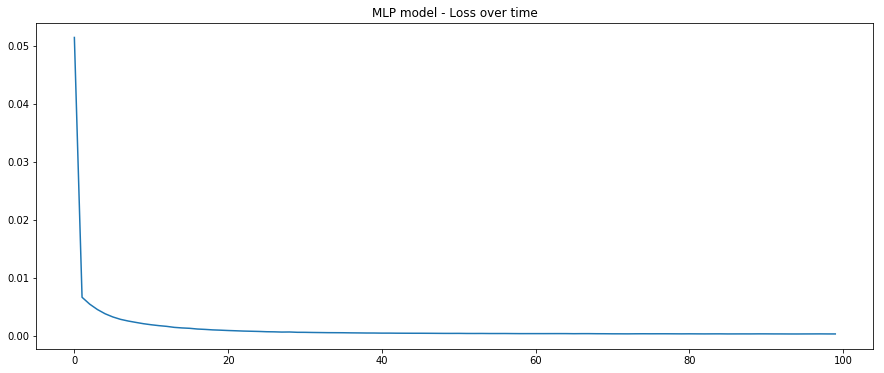

In [23]:
plot_series(history.history['loss'], title='MLP model - Loss over time')

In [24]:
model.save_weights('mlp-model_weights.h5')

In [25]:
size = 252 # approx. one year
predictions = NN_walk_forward_validation(model, 
                                         scaled_train, scaled_test[:252],
                                         size=size,
                                         look_back=look_back, 
                                         n_outputs=n_outputs)

In [26]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [27]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

descaled_preds = inv_boxcox(descaled_preds, lmbda)
descaled_test = inv_boxcox(descaled_test, lmbda)

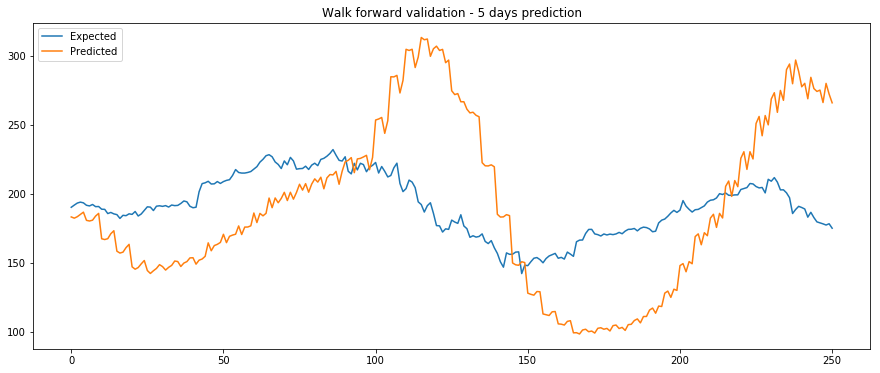

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

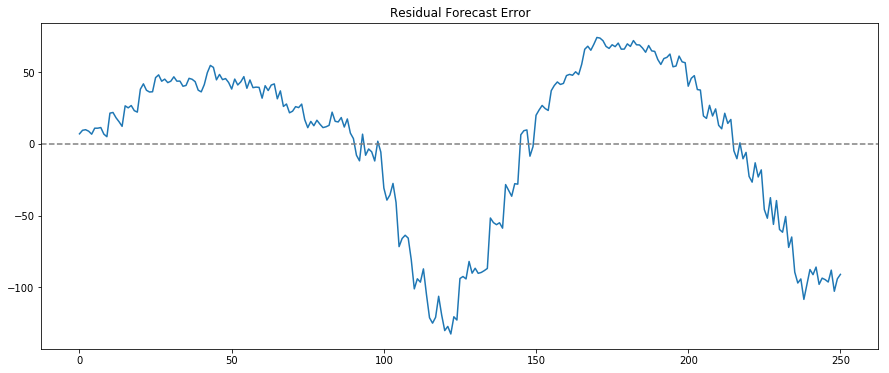

In [29]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [30]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='MLP', 
                          total_days=size, steps=n_outputs)

MLP[252 days, 5 days forecast]:

Forecast Bias: 0.635
MAE: 46.852
MSE: 3133.690
RMSE: 55.979
MAPE: 25.254


In [ ]:
# model.load_weights('mlp-model_weights.h5')